## Imports and Loading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import re

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
by_days = pd.read_pickle('data/sales_by_day.pkl')
by_days.head()

order_date
2015-01-01    2713.85
2015-01-02    2731.90
2015-01-03    2662.40
2015-01-04    1755.45
2015-01-05    2065.95
Name: total_price, dtype: float64

# ARIMA Modeling

Having taken a look at our data with rolling averages and standard deviations, the seasonal decomposition plots, the acf and pacf plots, adfuller test results, and BP test results, we're fairly certain our data is stationary when the outliers are removed. The decomposition plots, the rolling statistic plots, the adfuller test, and the BP test tell us that our data has no trend and constant variance. Since no differencing was needed to achieve stationarity the d parameter of the ARIMA model (p, d, q) will likely be zero. The seasonal decomposition and basic time series plots tell us that our data has a high degree of seasonality. The acf and pacf plots tell us that this seasonality comes in 7 day windows. Therefore, the S parameter of the seasonality orders (P, D, Q, S) will likely be seven. This exploratory data analysis is useful, but by no means deterministic with regards to all of the correct model order choices. The parameter space is constrained, but not fully determined. 

In this section we will start by fitting an out of the box ARIMA model, and then try successively finer tuned hyperparameters. Lastly, we will brute force a grid search for some model orders. Such a grid search could take an enormous amount of training time and computation power, as seven model orders varying from 0 to the length of the data set makes for a vast amount of combinations. But luckily, as noted above, we can narrow down the windows of some orders (the seasonality and differencing order).

In [3]:
# Designate train/test split. Since this is a time series, order matters. Therefore when making our split, we must preserve the order of data points. 
# To do this we simply take the first nine months for our training data and reserve the remaining three months for testing data.
train = by_days.loc[:'2015-08-31']
test = by_days.loc['2015-09-01':]

In [4]:
train.head()

order_date
2015-01-01    2713.85
2015-01-02    2731.90
2015-01-03    2662.40
2015-01-04    1755.45
2015-01-05    2065.95
Name: total_price, dtype: float64

In [5]:
# Create and fit the ARIMA model
# A first pass with all 0's for model orders
model = ARIMA(endog=train, order=(0, 0, 0), seasonal_order=(0, 0, 0, 0), freq = 'D')
results = model.fit()

In [6]:
# Create and store predictions for the date contained in the test set (September 1st through December 31st)
predictions = results.predict(start = test.index[0], end = test.index[-1])
predictions.sample(5)

2015-09-21    2282.123017
2015-10-07    2282.123017
2015-12-22    2282.123017
2015-10-16    2282.123017
2015-12-06    2282.123017
Name: predicted_mean, dtype: float64

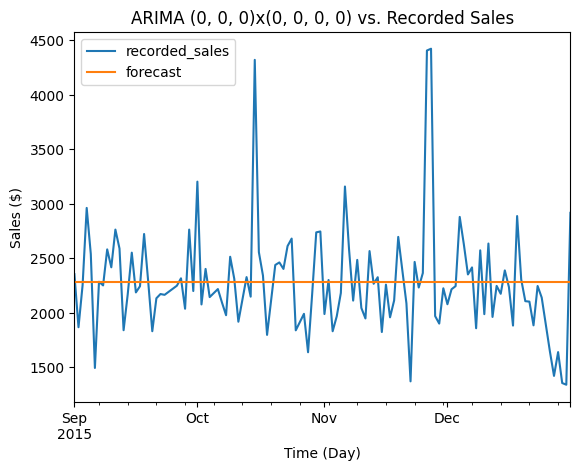

In [7]:
# Visually inspect the ARIMA model's predictions against the holdout set
forecast = pd.concat([test, predictions], axis = 1) # Assemble test set and forecast into one dataframe
forecast.rename(columns = {'total_price': 'recorded_sales', 'predicted_mean': 'forecast'}, inplace = True) # rename columns to be more intuitive
forecast.plot()
plt.title(f'ARIMA {model.order}x{model.seasonal_order} vs. Recorded Sales')
plt.xlabel('Time (Day)')
plt.ylabel('Sales ($)')
plt.show()

In [8]:
# Create dictionary to store model orders and error metrics for comparison
scoring_dict = {}

# Obtain and inspect two error metrics: Root Mean Squared Error and Mean Absolute Error
rmse = np.round(np.sqrt(mean_squared_error(test, predictions)), 2)
mae = np.round(mean_absolute_error(test, predictions), 2)

# View numerical performance
scoring_dict = {'Model 1' : [f'{model.order}x{model.seasonal_order}', {'scores': {'RMSE':rmse, 'MAE':mae}}]}
scoring_dict

{'Model 1': ['(0, 0, 0)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 482.43, 'MAE': 318.21}}]}

Using all 0's for an ARIMA model is hardly using one at all. To do so says none of the previous values or previous error values are used in predicting the future values. The result is a horizontal line equal to the series's mean. This model captures none of the shape of the data, we most certainly can do better.

### Begin Fiddling with ARIMA model orders

In [9]:
# Create and fit the ARIMA model
model2 = ARIMA(endog=train, order=(1, 0, 0), seasonal_order=(0, 0, 0, 0), freq = 'D')
results2 = model2.fit()

In [10]:
# Create and store predictions for the beginning of the range of dates contained in the test set (September 1st through December 31st)
predictions2 = results2.predict(start = test.index[0], end = test.index[-1])
predictions2.sample(5)

2015-11-10    2282.123045
2015-11-14    2282.123045
2015-11-20    2282.123045
2015-12-15    2282.123045
2015-11-25    2282.123045
Name: predicted_mean, dtype: float64

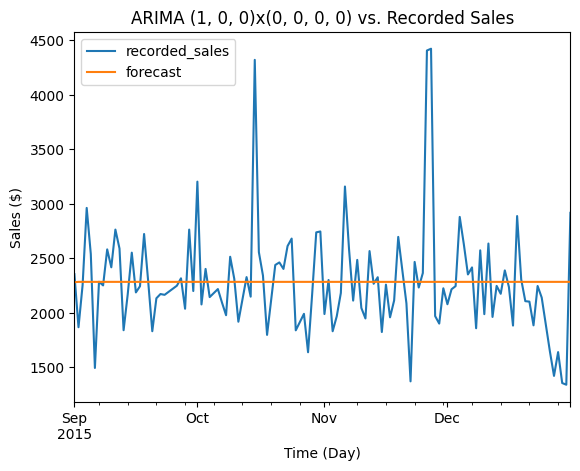

In [11]:
# Visually inspect the ARIMA model's predictions against the holdout set
forecast2 = pd.concat([test, predictions2], axis = 1) # Assemble test set and forecast into one dataframe
forecast2.rename(columns = {'total_price': 'recorded_sales', 'predicted_mean': 'forecast'}, inplace = True) # rename columns to be more intuitive
forecast2.plot()
plt.title(f'ARIMA {model2.order}x{model2.seasonal_order} vs. Recorded Sales')
plt.xlabel('Time (Day)')
plt.ylabel('Sales ($)')
plt.show()

In [12]:
# Obtain and inspect two error metrics: Root Mean Squared Error and Mean Absolute Error
rmse2 = np.round(np.sqrt(mean_squared_error(test, predictions2)), 2)
mae2 = np.round(mean_absolute_error(test, predictions2), 2)

# View numerical performance
scoring_dict['Model 2'] = [f'{model2.order}x{model2.seasonal_order}', {'scores': {'RMSE':rmse2, 'MAE':mae2}}]
scoring_dict

{'Model 1': ['(0, 0, 0)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 482.43, 'MAE': 318.21}}],
 'Model 2': ['(1, 0, 0)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 482.43, 'MAE': 318.24}}]}

### Another

In [13]:
# Create and fit the ARIMA model
model3 = ARIMA(endog=train, order=(0, 0, 1), seasonal_order=(0, 0, 0, 0), freq = 'D')
results3 = model3.fit()

In [14]:
# Create and store predictions for the beginning of the range of dates contained in the test set (September 1st through December 31st)
predictions3 = results3.predict(start = test.index[0], end = test.index[-1])
predictions3.sample(5)

2015-09-19    2282.123046
2015-11-19    2282.123046
2015-10-14    2282.123046
2015-09-14    2282.123046
2015-09-11    2282.123046
Name: predicted_mean, dtype: float64

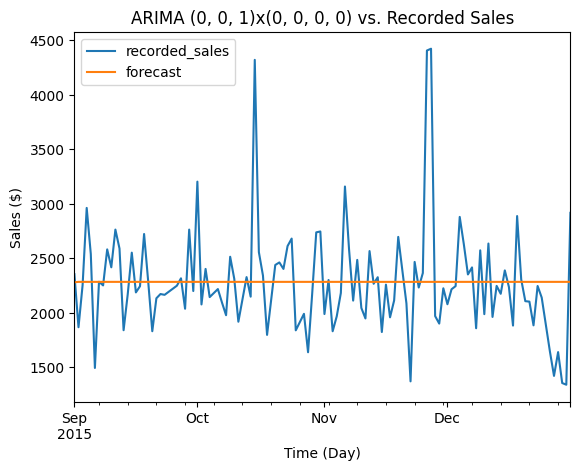

In [15]:
# Visually inspect the ARIMA model's predictions against the holdout set
forecast3 = pd.concat([test, predictions3], axis = 1) # Assemble test set and forecast into one dataframe
forecast3.rename(columns = {'total_price': 'recorded_sales', 'predicted_mean': 'forecast'}, inplace = True) # rename columns to be more intuitive
forecast3.plot()
plt.title(f'ARIMA {model3.order}x{model3.seasonal_order} vs. Recorded Sales')
plt.xlabel('Time (Day)')
plt.ylabel('Sales ($)')
plt.show()

In [16]:
# Obtain and inspect two error metrics: Root Mean Squared Error and Mean Absolute Error
rmse3 = np.round(np.sqrt(mean_squared_error(test, predictions3)), 2)
mae3 = np.round(mean_absolute_error(test, predictions3), 2)

# View numerical performance
scoring_dict['Model 3'] = [f'{model3.order}x{model3.seasonal_order}', {'scores': {'RMSE':rmse3, 'MAE':mae3}}]
scoring_dict

{'Model 1': ['(0, 0, 0)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 482.43, 'MAE': 318.21}}],
 'Model 2': ['(1, 0, 0)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 482.43, 'MAE': 318.24}}],
 'Model 3': ['(0, 0, 1)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 482.43, 'MAE': 318.25}}]}

### Another

In [17]:
# Create and fit the ARIMA model
model4 = ARIMA(endog=train, order=(1, 0, 1), seasonal_order=(0, 0, 0, 0), freq = 'D')
results4 = model4.fit()

In [18]:
# Create and store predictions for the beginning of the range of dates contained in the test set (September 1st through December 31st)
predictions4 = results4.predict(start = test.index[0], end = test.index[-1])
predictions4.sample(5)

2015-11-19    2290.909686
2015-09-07    2398.100683
2015-11-22    2290.902024
2015-09-11    2358.899986
2015-12-18    2290.884169
Name: predicted_mean, dtype: float64

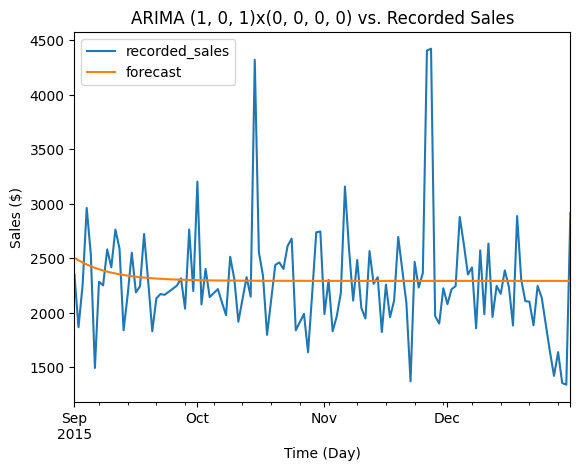

In [19]:
# Visually inspect the ARIMA model's predictions against the holdout set
forecast4 = pd.concat([test, predictions4], axis = 1) # Assemble test set and forecast into one dataframe
forecast4.rename(columns = {'total_price': 'recorded_sales', 'predicted_mean': 'forecast'}, inplace = True) # rename columns to be more intuitive
forecast4.plot()
plt.title(f'ARIMA {model4.order}x{model4.seasonal_order} vs. Recorded Sales')
plt.xlabel('Time (Day)')
plt.ylabel('Sales ($)')
plt.show()

In [20]:
# Obtain and inspect two error metrics: Root Mean Squared Error and Mean Absolute Error
rmse4 = np.round(np.sqrt(mean_squared_error(test, predictions4)), 2)
mae4 = np.round(mean_absolute_error(test, predictions4))

# View numerical performance
scoring_dict['Model 4'] = [f'{model4.order}x{model4.seasonal_order}', {'scores': {'RMSE':rmse4, 'MAE':mae4}}]
scoring_dict

{'Model 1': ['(0, 0, 0)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 482.43, 'MAE': 318.21}}],
 'Model 2': ['(1, 0, 0)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 482.43, 'MAE': 318.24}}],
 'Model 3': ['(0, 0, 1)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 482.43, 'MAE': 318.25}}],
 'Model 4': ['(1, 0, 1)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 484.2, 'MAE': 324.0}}]}

### Another

In [21]:
# Create and fit the ARIMA model
model5 = ARIMA(endog=train, order=(0, 0, 0), seasonal_order=(1, 0, 0, 7), freq = 'D')
results5 = model5.fit()

In [22]:
# Create and store predictions for the beginning of the range of dates contained in the test set (September 1st through December 31st)
predictions5 = results5.predict(start = test.index[0], end = test.index[-1])
predictions5.sample(5)

2015-09-10    2258.350967
2015-09-16    2284.720854
2015-11-11    2282.124174
2015-10-29    2282.095752
2015-12-21    2282.123002
Name: predicted_mean, dtype: float64

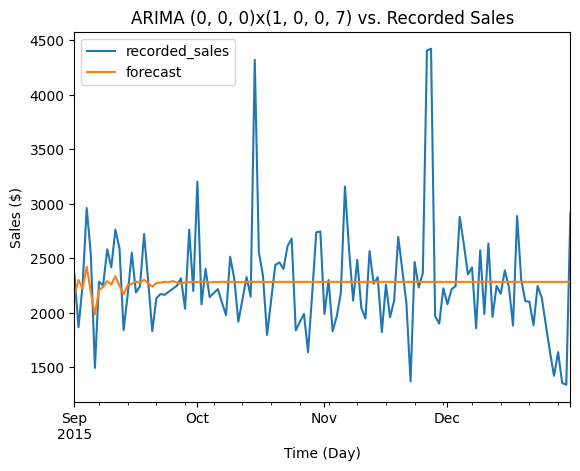

In [23]:
# Visually inspect the ARIMA model's predictions against the holdout set
forecast5 = pd.concat([test, predictions5], axis = 1) # Assemble test set and forecast into one dataframe
forecast5.rename(columns = {'total_price': 'recorded_sales', 'predicted_mean': 'forecast'}, inplace = True) # rename columns to be more intuitive
forecast5.plot()
plt.title(f'ARIMA {model5.order}x{model5.seasonal_order} vs. Recorded Sales')
plt.xlabel('Time (Day)')
plt.ylabel('Sales ($)')
plt.show()

In [24]:
# Obtain and inspect two error metrics: Root Mean Squared Error and Mean Absolute Error
rmse5 = np.round(np.sqrt(mean_squared_error(test, predictions5)), 2)
mae5 = np.round(mean_absolute_error(test, predictions5), 2)

# View numerical performance
scoring_dict['Model 5'] = [f'{model5.order}x{model5.seasonal_order}', {'scores': {'RMSE':rmse5, 'MAE':mae5}}]
scoring_dict

{'Model 1': ['(0, 0, 0)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 482.43, 'MAE': 318.21}}],
 'Model 2': ['(1, 0, 0)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 482.43, 'MAE': 318.24}}],
 'Model 3': ['(0, 0, 1)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 482.43, 'MAE': 318.25}}],
 'Model 4': ['(1, 0, 1)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 484.2, 'MAE': 324.0}}],
 'Model 5': ['(0, 0, 0)x(1, 0, 0, 7)',
  {'scores': {'RMSE': 477.24, 'MAE': 315.48}}]}

Finally, including the seasonal orders starts to budge the root mean squared error.

### Another

In [25]:
# Create and fit the ARIMA model
model6 = ARIMA(endog=train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 7), freq = 'D')
results6 = model6.fit()

In [26]:
# Create and store predictions for the beginning of the range of dates contained in the test set (September 1st through December 31st)
predictions6 = results6.predict(start = test.index[0], end = test.index[-1])
predictions6.sample(5)

2015-09-21    2276.383615
2015-10-16    2687.200502
2015-11-04    2247.485162
2015-10-01    2290.180917
2015-11-16    2253.602342
Name: predicted_mean, dtype: float64

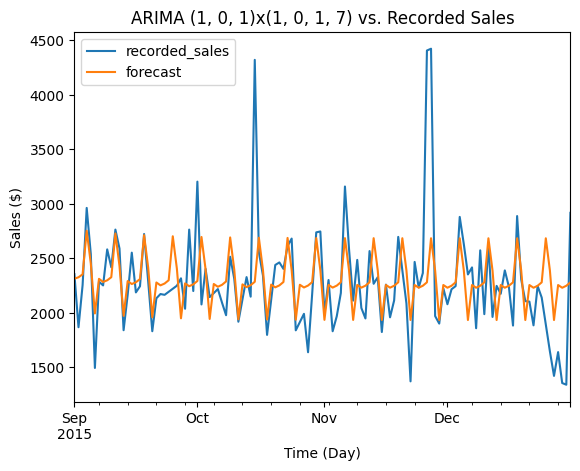

In [27]:
# Visually inspect the ARIMA model's predictions against the holdout set
forecast6 = pd.concat([test, predictions6], axis = 1) # Assemble test set and forecast into one dataframe
forecast6.rename(columns = {'total_price': 'recorded_sales', 'predicted_mean': 'forecast'}, inplace = True) # rename columns to be more intuitive
forecast6.plot()
plt.title(f'ARIMA {model6.order}x{model6.seasonal_order} vs. Recorded Sales')
plt.xlabel('Time (Day)')
plt.ylabel('Sales ($)')
plt.show()

In [28]:
# Obtain and inspect two error metrics: Root Mean Squared Error and Mean Absolute Error
rmse6 = np.round(np.sqrt(mean_squared_error(test, predictions6)), 2)
mae6 = np.round(mean_absolute_error(test, predictions6), 2)

# View numerical performance
scoring_dict['Model 6'] = [f'{model6.order}x{model6.seasonal_order}', {'scores': {'RMSE':rmse6, 'MAE':mae6}}]
scoring_dict

{'Model 1': ['(0, 0, 0)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 482.43, 'MAE': 318.21}}],
 'Model 2': ['(1, 0, 0)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 482.43, 'MAE': 318.24}}],
 'Model 3': ['(0, 0, 1)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 482.43, 'MAE': 318.25}}],
 'Model 4': ['(1, 0, 1)x(0, 0, 0, 0)',
  {'scores': {'RMSE': 484.2, 'MAE': 324.0}}],
 'Model 5': ['(0, 0, 0)x(1, 0, 0, 7)',
  {'scores': {'RMSE': 477.24, 'MAE': 315.48}}],
 'Model 6': ['(1, 0, 1)x(1, 0, 1, 7)',
  {'scores': {'RMSE': 432.99, 'MAE': 272.31}}]}

Including seasonal components as well as ARMA components makes a huge difference. From the plot you can see that the model has begun to approximate the test set much better than the previous iterations, which were mostly straight lines. Accordingly, the rmse dropped by about 40 dollars which has been by far the greatest decrease in error. As a side note, the mean absolute error is generally doing much better with these models. That is because our data has some pretty wild outliers and mae is more insulated against outliers. 

The above process of iteratively changing model orders and looking at performance is instructive, but not very efficient. Rather than manually iterate through every possible combination of model orders, within a reasonably constrained space, we will leverage an exhustive grid search style of order optimization. This will allow us to algorithmically determine the best model orders within the space we give it and with respect to rmse. As noted above, our eda has allowed us to narrow down on some model orders, reducing the amount of order combinations from the thousands to about one hundred. 

# Gridsearch To Algorithmically Determine Model Orders

In [29]:
# Function to test ARIMA parameter grid combinations
def SARIMA_grid(train, test, param_grid):
    scoring_df = pd.DataFrame()
    orders = []
    rootmse = []
    meanae = []
    
    for order in param_grid['order']:
        for seasonal_order in param_grid['seasonal_order']:
            try:
                model = ARIMA(endog=train, order = order, seasonal_order = seasonal_order, freq = 'D')
                results = model.fit()
            
                predictions = results.predict(start = test.index[0], end = test.index[-1])

                rmse = np.round(np.sqrt(mean_squared_error(test, predictions)), 2)
                mae = np.round(mean_absolute_error(test, predictions), 2)
                
                orders.append(f'{model.order}x{model.seasonal_order}')
                rootmse.append(rmse)
                meanae.append(mae)
                
            except Exception as e:
                print('Error created with', order, seasonal_order)
                print(f"An error occurred: {e}")
                pass
    scoring_df['order'] = orders
    scoring_df['rmse'] = rootmse
    scoring_df['mae'] = meanae
    return scoring_df

In [30]:
param_grid = {
    'order': [(p, d, q) for p in range(1, 3) for d in range(0, 2) for q in range(1, 3)],
    'seasonal_order': [(P, D, Q, 7) for P in range(1, 3) for D in range(0, 3) for Q in range(1, 3)]
}

gridsearch_df = SARIMA_grid(train, test, param_grid)

Error created with (1, 1, 2) (2, 2, 2, 7)
An error occurred: LU decomposition error.
Error created with (2, 0, 2) (1, 0, 1, 7)
An error occurred: LU decomposition error.
Error created with (2, 0, 2) (2, 2, 1, 7)
An error occurred: LU decomposition error.
Error created with (2, 1, 1) (2, 1, 2, 7)
An error occurred: LU decomposition error.
Error created with (2, 1, 2) (2, 0, 1, 7)
An error occurred: LU decomposition error.


In [31]:
gridsearch_df.sort_values(by = 'rmse').head()

,order,rmse,mae
21,"(1, 0, 2)x(2, 1, 2, 7)",430.70,270.56
49,"(2, 0, 1)x(1, 1, 1, 7)",430.83,270.82
42,"(1, 1, 2)x(2, 0, 1, 7)",430.91,270.54
3,"(1, 0, 1)x(1, 1, 2, 7)",431.22,270.75
76,"(2, 1, 1)x(2, 0, 2, 7)",431.31,269.19


In [32]:
# Get the index of the row with the minimum RMSE
best_index = gridsearch_df['rmse'].idxmin()

# Extract the best order and seasonal order using regex and the index
order_str = gridsearch_df.loc[best_index, 'order']
matches = re.match(r"\((\d, \d, \d)\)x\((\d, \d, \d, \d)\)", order_str)

best_orders = tuple(map(int, matches.group(1).split(', ')))
best_seasonal_orders = tuple(map(int, matches.group(2).split(', ')))

best_orders, best_seasonal_orders

((1, 0, 2), (2, 1, 2, 7))

In [36]:
# Now that we've extracted the best performing model orders, retrain the model with those orders so we can use that model for graphing etc.
model = ARIMA(endog=train, order =  best_orders, seasonal_order = best_seasonal_orders, freq = 'D')
best_results = model.fit()
best_forecast = best_results.get_forecast(steps=len(test))
mean_forecast = best_forecast.predicted_mean
confidence_intervals = best_forecast.conf_int()

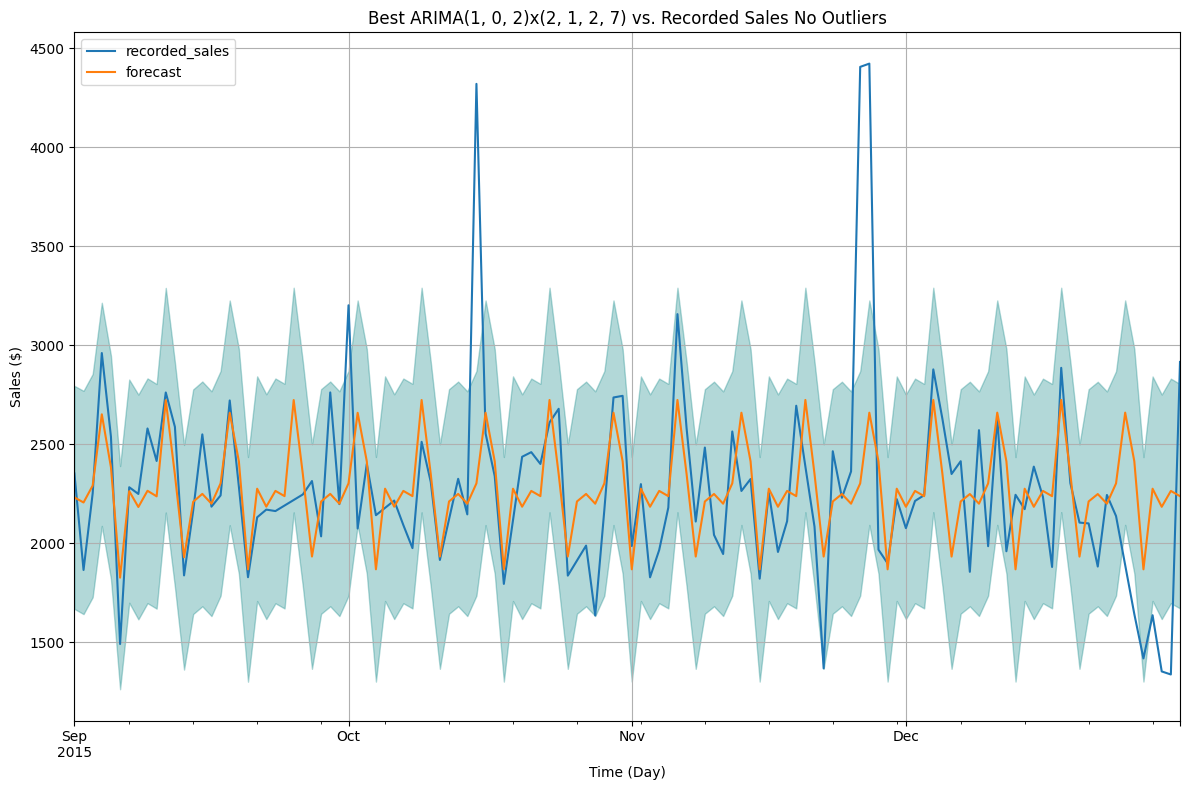

In [37]:
# Assemble test set and forecast into one dataframe
forecast_df = pd.concat([test, mean_forecast], axis=1)
forecast_df.columns = ['recorded_sales', 'forecast']

# Plotting the results
forecast_df.plot(figsize=(12, 8))

# Filling the area between the confidence intervals
plt.fill_between(confidence_intervals.index, 
                 confidence_intervals.iloc[:, 0], 
                 confidence_intervals.iloc[:, 1], 
                 color='teal', alpha=0.3)  # Making the fill slightly transparent

plt.title(f'Best ARIMA{model.order}x{model.seasonal_order} vs. Recorded Sales No Outliers')
plt.xlabel('Time (Day)')
plt.ylabel('Sales ($)')
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()


# Test ARIMA Performance with Outlier Removal

As we have seen from the exploratory data analysis, our data has a small handful of days with extreme outliers. All of the test set/model plots above show some of these outliers, huge spikes in sales that the model didn't even come close to anticipating. Here we bring in that version of the data with those outliers removed to see how much better error we can get from ARIMA.

In [38]:
by_days_no_outliers = pd.read_pickle('data/sales_by_day_no_outliers.pkl')

In [39]:
# Redefine train/test from by_days_no_outliers, since original train/test were from by_days
train_no_outliers = by_days_no_outliers.loc[:'2015-08-31']
test_no_outliers = by_days_no_outliers.loc['2015-09-01':]

# Run grid search function again with outlier free train and test data
gridsearch_df_no_outliers = SARIMA_grid(train_no_outliers, test_no_outliers, param_grid)

gridsearch_df_no_outliers.sort_values(by = 'rmse').head()

Error created with (2, 0, 1) (2, 0, 2, 7)
An error occurred: LU decomposition error.
Error created with (2, 0, 1) (2, 1, 2, 7)
An error occurred: LU decomposition error.
Error created with (2, 0, 2) (1, 1, 2, 7)
An error occurred: LU decomposition error.
Error created with (2, 0, 2) (2, 1, 1, 7)
An error occurred: LU decomposition error.
Error created with (2, 0, 2) (2, 2, 1, 7)
An error occurred: LU decomposition error.


,order,rmse,mae
80,"(2, 1, 2)x(1, 0, 2, 7)",254.58,199.08
64,"(2, 0, 2)x(2, 0, 2, 7)",254.60,200.72
63,"(2, 0, 2)x(2, 0, 1, 7)",254.66,202.39
37,"(1, 1, 2)x(1, 0, 2, 7)",254.87,202.32
86,"(2, 1, 2)x(2, 0, 2, 7)",255.03,198.75


In [40]:
# For comparison, with the outliers still present
gridsearch_df['rmse'].sort_values()[0]

432.99

In [41]:
gridsearch_df['rmse'].sort_values()[0] - gridsearch_df_no_outliers['rmse'].sort_values()[0]

175.28000000000003

About 170 dollars better root mean squared error! Below we visually see how much of a better fit the model can produce on data without outliers.

In [42]:

# Get the index of the row with the minimum RMSE
best_index = gridsearch_df_no_outliers['rmse'].idxmin()

# Extract the best order and seasonal order using regex and the index
order_str = gridsearch_df_no_outliers.loc[best_index, 'order']
matches = re.match(r"\((\d, \d, \d)\)x\((\d, \d, \d, \d)\)", order_str)

best_orders_no_outliers = tuple(map(int, matches.group(1).split(', ')))
best_seasonal_orders_no_outliers = tuple(map(int, matches.group(2).split(', ')))

best_orders_no_outliers, best_seasonal_orders_no_outliers

((2, 1, 2), (1, 0, 2, 7))

In [44]:
# Now that we've extracted the best performing model orders, retrain the model with those orders so we can use that model for graphing etc.
model = ARIMA(endog=train_no_outliers, order =  best_orders_no_outliers, seasonal_order = best_seasonal_orders_no_outliers, freq = 'D')
best_results_no_outliers = model.fit()
best_forecast_no_outliers = best_results_no_outliers.get_forecast(steps=len(test))
mean_forecast = best_forecast_no_outliers.predicted_mean
confidence_intervals = best_forecast_no_outliers.conf_int()

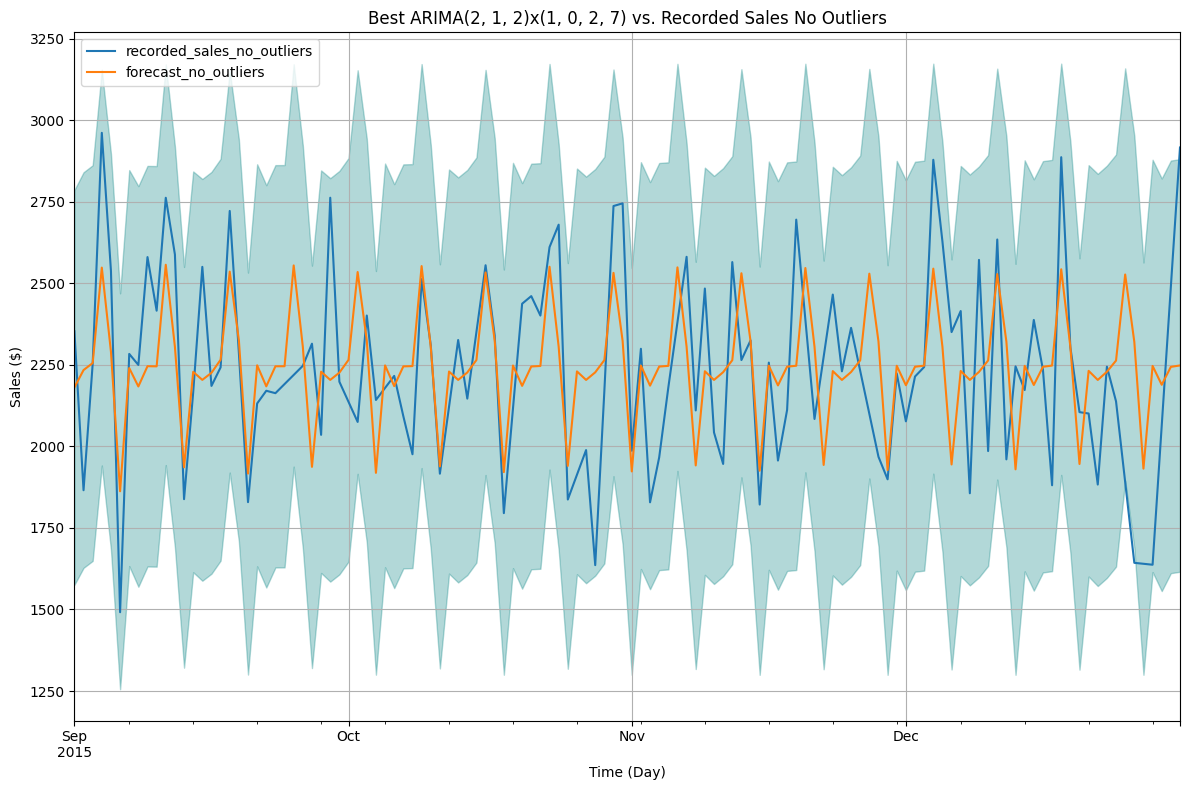

In [45]:
# Assemble test set and forecast into one dataframe
forecast_df = pd.concat([test_no_outliers, mean_forecast], axis=1)
forecast_df.columns = ['recorded_sales_no_outliers', 'forecast_no_outliers']

# Plotting the results
forecast_df.plot(figsize=(12, 8))

# Filling the area between the confidence intervals
plt.fill_between(confidence_intervals.index, 
                 confidence_intervals.iloc[:, 0], 
                 confidence_intervals.iloc[:, 1], 
                 color='teal', alpha=0.3)  # Making the fill slightly transparent

plt.title(f'Best ARIMA{model.order}x{model.seasonal_order} vs. Recorded Sales No Outliers')
plt.xlabel('Time (Day)')
plt.ylabel('Sales ($)')
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()


# Baseline Comparison
Your model's performance means only so much on its own. Often we find ourselves needing to know how well our model has done *compared to* the current model, or compared to some baseline. Here we explore different baselines and see what their error metrics are like.

To begin with, we'll test against a seasonal naive forecast that simply predicts next week's sales will be exactly the same as last week's sales.

In [46]:
# Generate Seasonal Naive Forecast
seasonal_naive_forecast = test_no_outliers.shift(7)

# Remove NaN values produced by the shift operation
seasonal_naive_forecast.rename('seasonal_naive_forecast2', inplace = True).dropna(inplace=True)

# Compute error metrics for seasonal naive forecast against original test set (without outliers)
naive_rmse = np.sqrt(mean_squared_error(test_no_outliers[7:], seasonal_naive_forecast))
naive_mae = mean_absolute_error(test_no_outliers[7:], seasonal_naive_forecast)
print(f'Naive Forecast RMSE (without outliers): {naive_rmse}')
print(f'Naive Forecast MAE (without outliers): {naive_mae}')

Naive Forecast RMSE (without outliers): 319.78530846344074
Naive Forecast MAE (without outliers): 248.8354347826087


319.79 RMSE without outliers. Not bad, only about $70 dollars worse than the ARIMA model.

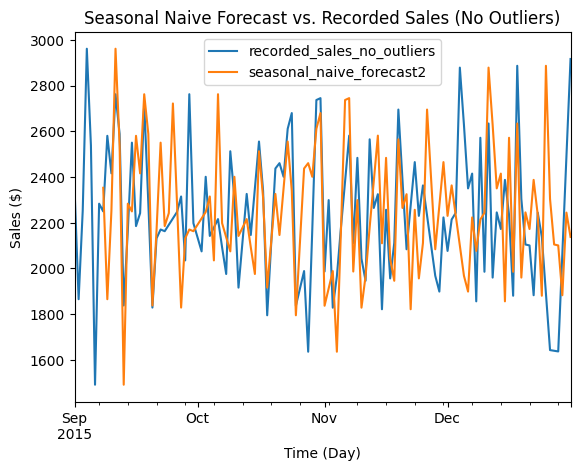

In [47]:
# Visually inspect naive forecase against test set
forecast = pd.concat([test_no_outliers, seasonal_naive_forecast], axis = 1) # Assemble test set and forecast into one dataframe
forecast.rename(columns = {'total_price': 'recorded_sales_no_outliers'}, inplace = True) # rename columns to be more intuitive
forecast.plot()
plt.title(f'Seasonal Naive Forecast vs. Recorded Sales (No Outliers)')
plt.xlabel('Time (Day)')
plt.ylabel('Sales ($)')
plt.show()

Next we try to introduce some noise to the naive seasonal forecase to try and better simulate the unpredictability of actual sales. This new more sophisticated yet still naive model will serve as another point of comparison.

In [48]:
# Store array of noise variable: random numbers with equal chance to be chosen +/- one standard deviation of the daily sales
noise = np.random.uniform(-test_no_outliers.std(), test_no_outliers.std(), size = len(seasonal_naive_forecast))

# Add noise onto the naive seasonal forecast
noisy_seasonal_naive_forecast = seasonal_naive_forecast + noise

# Calculate error
noisy_naive_rmse = np.sqrt(mean_squared_error(test_no_outliers[7:], noisy_seasonal_naive_forecast))
noisy_naive_mae = np.sqrt(mean_absolute_error(test_no_outliers[7:], noisy_seasonal_naive_forecast))
print(f'Noisy Naive Forecast RMSE (without outliers): {noisy_naive_rmse}')
print(f'Noisy Naive Forecast MAE (without outliers): {noisy_naive_mae}')

Noisy Naive Forecast RMSE (without outliers): 363.45506962075757
Noisy Naive Forecast MAE (without outliers): 16.948479479529635


In [49]:
naive_rmse - noisy_naive_rmse

-43.66976115731683

Adding in the noise makes the naive model perform worse.

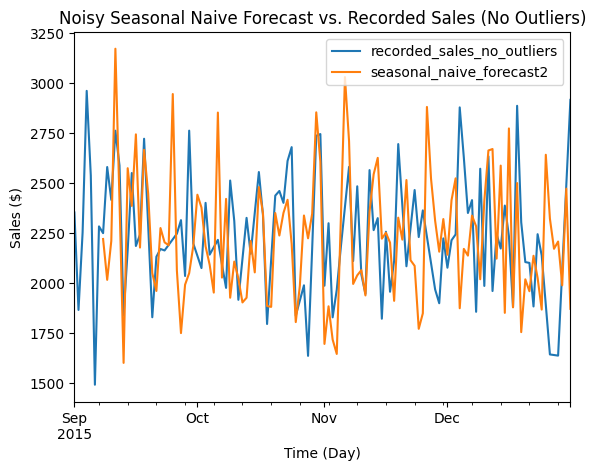

In [50]:
# Visually inspect noisy naive forecast against test set
forecast = pd.concat([test_no_outliers, noisy_seasonal_naive_forecast], axis = 1) # Assemble test set and forecast into one dataframe
forecast.rename(columns = {'total_price': 'recorded_sales_no_outliers'}, inplace = True) # rename columns to be more intuitive
forecast.plot()
plt.title(f'Noisy Seasonal Naive Forecast vs. Recorded Sales (No Outliers)')
plt.xlabel('Time (Day)')
plt.ylabel('Sales ($)')
plt.show()

# Incorporate Exogenous Variables to ARIMAX Model

SARIMAX models are an extension of the ARIMA family of models that allow for exogenous variables (X), which act as further weights and can potentially add useful information into the system. We've obtained a dataset of some atmospheric data from the same region of New Jersey that our pizza restaurant is based and we'll try adding some of these columns to the SARIMAX model to see if these extra dimensions of data are useful for predicting daily sales. 

We'll start with just using precipitation, to see if that has any effect on pizza sales, and then try the two temperature columns.

In [51]:
columns_to_use = ['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'DATE', 'TMAX', 'TMIN', 'PRCP']
exog_df = pd.read_pickle('data/exogenous_variables.pkl')
exog_df.head()

,STATION,NAME,LATITUDE,LONGITUDE,DATE,PRCP,TMAX,TMIN
5251,USC00283704,"HARRISON, NJ US",40.7481,-74.152,2015-01-01,0.0,0.0,-5.0
5252,USC00283704,"HARRISON, NJ US",40.7481,-74.152,2015-01-02,0.0,3.3,-5.0
5253,USC00283704,"HARRISON, NJ US",40.7481,-74.152,2015-01-03,0.0,6.1,-1.7
5254,USC00283704,"HARRISON, NJ US",40.7481,-74.152,2015-01-04,27.4,5.6,0.0
5255,USC00283704,"HARRISON, NJ US",40.7481,-74.152,2015-01-05,3.0,12.2,4.4


In [52]:
# Subsetting Precipitation from the dataframe
precip = exog_df[['PRCP']]
precip = precip.head(-1)

In [53]:
precip.set_index(by_days_no_outliers.index, inplace = True)
precip.head()

,PRCP
order_date,
2015-01-01,0.0
2015-01-02,0.0
2015-01-03,0.0
2015-01-04,27.4
2015-01-05,3.0


In [54]:
# Splitting the exogenous data
trainPrecip = precip.loc[:'2015-08-31']
testPrecip = precip.loc['2015-09-01':]

In [55]:
# Function to test ARIMA parameter grid combinations. Just a slight modification of the original to account for the inclusion of an exogenous variable set
def SARIMAX_grid(train, test, param_grid, train_exog, test_exog, ):
    scoring_df = pd.DataFrame()
    orders = []
    rootmse = []
    meanae = []
    
    for order in param_grid['order']:
        for seasonal_order in param_grid['seasonal_order']:
            try:
                model = ARIMA(endog=train, exog=train_exog, order = order, seasonal_order = seasonal_order, freq = 'D')
                results = model.fit()
            
                predictions = results.predict(start = test.index[0], end = test.index[-1], exog=test_exog)

                rmse = np.round(np.sqrt(mean_squared_error(test, predictions)), 2)
                mae = np.round(mean_absolute_error(test, predictions), 2)
                
                orders.append(f'{model.order}x{model.seasonal_order}')
                rootmse.append(rmse)
                meanae.append(mae)
                
            except Exception as e:
                print('Error created with', order, seasonal_order)
                print(f"An error occurred: {e}")
                pass

    scoring_df['order'] = orders
    scoring_df['rmse'] = rootmse
    scoring_df['mae'] = meanae
    return scoring_df

In [56]:
# Apply order gridsearch to sales using precipitation as the exogenous variable
exogenous_score_df_no_outliers = SARIMAX_grid(train_no_outliers, test_no_outliers, param_grid, trainPrecip, testPrecip,)

Error created with (2, 0, 2) (1, 0, 1, 7)
An error occurred: LU decomposition error.
Error created with (2, 0, 2) (1, 1, 2, 7)
An error occurred: LU decomposition error.
Error created with (2, 1, 1) (2, 0, 2, 7)
An error occurred: LU decomposition error.


In [57]:
exogenous_score_df_no_outliers.sort_values(by='rmse').head()

,order,rmse,mae
0,"(1, 0, 1)x(1, 0, 1, 7)",256.05,201.30
60,"(2, 0, 2)x(1, 0, 2, 7)",256.58,203.84
81,"(2, 1, 2)x(1, 0, 1, 7)",256.59,203.30
12,"(1, 0, 2)x(1, 0, 1, 7)",256.79,201.94
65,"(2, 0, 2)x(2, 0, 2, 7)",256.93,204.16


In [58]:
print('Adding in the exogenous variable of precipitation gets', exogenous_score_df_no_outliers['rmse'].sort_values()[0], 'rmse')
print('For comparison, without the precipitation data, the rmse was', gridsearch_df_no_outliers['rmse'].sort_values()[0], 'rmse')

Adding in the exogenous variable of precipitation gets 256.05 rmse
For comparison, without the precipitation data, the rmse was 257.71 rmse


It looks like adding in precipitation helped by a tiny bit! About 1 dollar rmse.

# Temperature

In [59]:
#Subsetting the temperature columns from the dataframe
temp = exog_df[['TMAX', 'TMIN']]
temp = temp.head(-1)
temp.head()

,TMAX,TMIN
5251,0.0,-5.0
5252,3.3,-5.0
5253,6.1,-1.7
5254,5.6,0.0
5255,12.2,4.4


In [60]:
temp.set_index(by_days_no_outliers.index, inplace = True)
temp.head()

,TMAX,TMIN
order_date,,
2015-01-01,0.0,-5.0
2015-01-02,3.3,-5.0
2015-01-03,6.1,-1.7
2015-01-04,5.6,0.0
2015-01-05,12.2,4.4


In [61]:
#Splitting the exogenous data
trainTemp = temp.loc[:'2015-08-31']
testTemp = temp.loc['2015-09-01':]

In [62]:
temp_exog_score_df_no_outliers = SARIMAX_grid(train_no_outliers, test_no_outliers, param_grid, trainTemp, testTemp,)

Error created with (2, 0, 1) (2, 0, 2, 7)
An error occurred: LU decomposition error.
Error created with (2, 0, 2) (1, 2, 1, 7)
An error occurred: LU decomposition error.
Error created with (2, 0, 2) (2, 0, 2, 7)
An error occurred: LU decomposition error.
Error created with (2, 1, 1) (2, 0, 2, 7)
An error occurred: LU decomposition error.


In [63]:
temp_exog_score_df_no_outliers.sort_values(by='rmse').head()

,order,rmse,mae
49,"(2, 0, 1)x(1, 0, 2, 7)",258.11,201.31
19,"(1, 0, 2)x(2, 0, 2, 7)",258.18,200.11
48,"(2, 0, 1)x(1, 0, 1, 7)",258.54,200.39
7,"(1, 0, 1)x(2, 0, 2, 7)",259.23,200.50
6,"(1, 0, 1)x(2, 0, 1, 7)",259.63,200.75


In [64]:
print('Adding in the exogenous variable of precipitation gets', exogenous_score_df_no_outliers['rmse'].sort_values()[0], 'rmse')
print('For comparison, adding in temperature instead of preceiptation the rmse was', temp_exog_score_df_no_outliers['rmse'].sort_values()[0], 'rmse')
print('And with no exogenous variables the best performing model at an rmse of', gridsearch_df_no_outliers['rmse'].sort_values()[0], 'rmse')

Adding in the exogenous variable of precipitation gets 256.05 rmse
For comparison, adding in temperature instead of preceiptation the rmse was 261.61 rmse
And with no exogenous variables the best performing model at an rmse of 257.71 rmse


In [65]:
# Lastly, out of curiousity, try precipitation AND temperature
all_exog = exog_df[['TMAX', 'TMIN', 'PRCP']]
all_exog = all_exog.head(-1)

all_exog.set_index(by_days_no_outliers.index, inplace = True)

#Splitting the exogenous data
trainAll = all_exog.loc[:'2015-08-31']
testAll = all_exog.loc['2015-09-01':]

In [66]:
all_exog_score_df_no_outliers = SARIMAX_grid(train_no_outliers, test_no_outliers, param_grid, trainAll, testAll,)

Error created with (1, 0, 2) (2, 0, 2, 7)
An error occurred: LU decomposition error.
Error created with (1, 1, 1) (2, 0, 2, 7)
An error occurred: LU decomposition error.
Error created with (2, 0, 1) (2, 0, 2, 7)
An error occurred: LU decomposition error.
Error created with (2, 0, 2) (1, 0, 1, 7)
An error occurred: LU decomposition error.
Error created with (2, 0, 2) (1, 1, 1, 7)
An error occurred: LU decomposition error.
Error created with (2, 0, 2) (2, 0, 1, 7)
An error occurred: LU decomposition error.
Error created with (2, 0, 2) (2, 0, 2, 7)
An error occurred: LU decomposition error.
Error created with (2, 0, 2) (2, 1, 2, 7)
An error occurred: LU decomposition error.
Error created with (2, 0, 2) (2, 2, 2, 7)
An error occurred: LU decomposition error.


In [73]:
print('Adding in all the exogenous variables gets', all_exog_score_df_no_outliers['rmse'].sort_values()[0], 'rmse')
print('And with no exogenous variables the best performing model has an rmse of', gridsearch_df_no_outliers['rmse'].sort_values()[0], 'rmse')

Adding in all the exogenous variables gets 262.26 rmse
And with no exogenous variables the best performing model has an rmse of 257.71 rmse


In [68]:
# Get the index of the row with the minimum RMSE
best_index = all_exog_score_df_no_outliers['rmse'].idxmin()

# Extract the best order and seasonal order using regex and the index
order_str = all_exog_score_df_no_outliers.loc[best_index, 'order']
matches = re.match(r"\((\d, \d, \d)\)x\((\d, \d, \d, \d)\)", order_str)

best_orders_no_outliers_allExog = tuple(map(int, matches.group(1).split(', ')))
best_seasonal_orders_no_outliers_allExog = tuple(map(int, matches.group(2).split(', ')))


best_orders_no_outliers_allExog, best_seasonal_orders_no_outliers_allExog

((1, 0, 2), (1, 0, 1, 7))

In [69]:
#pulling model results to graph
model = ARIMA(endog=train_no_outliers, exog=trainAll, order = best_orders_no_outliers_allExog, seasonal_order = best_seasonal_orders_no_outliers_allExog, freq = 'D')
results = model.fit()
forecast = results.get_forecast(steps=len(test_no_outliers), exog=testAll)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

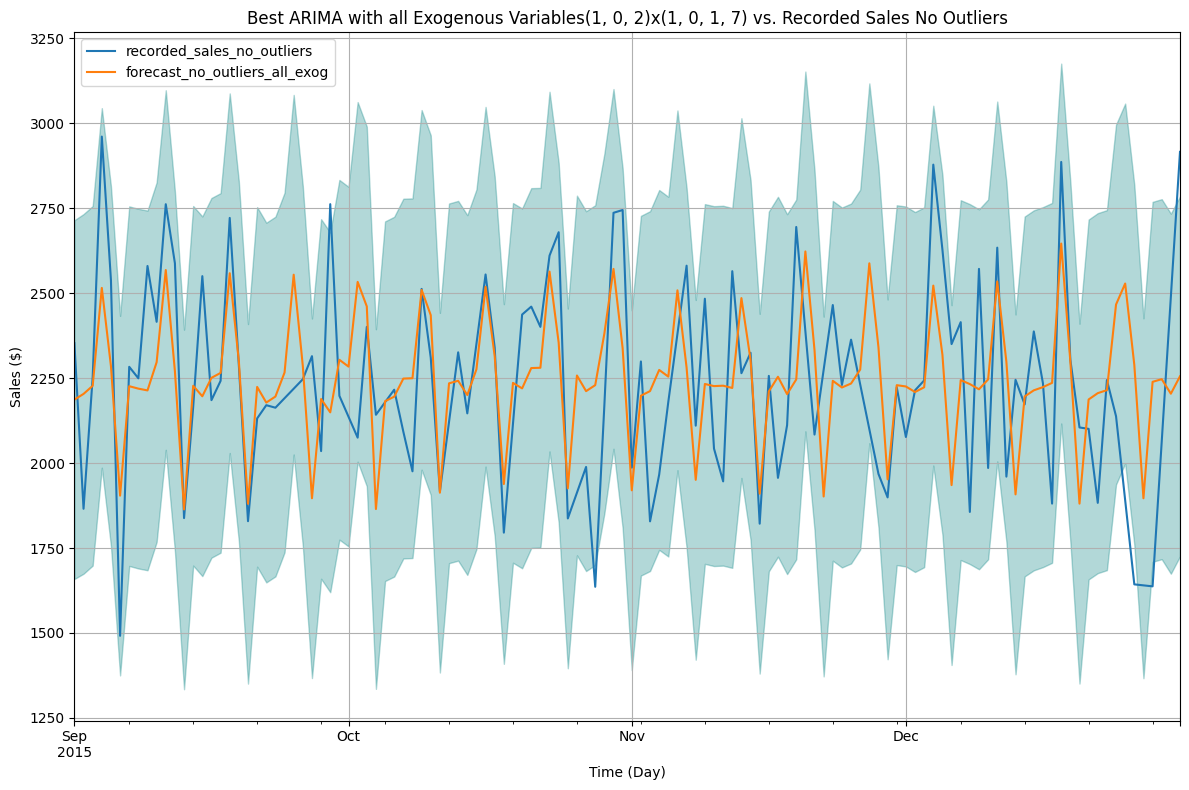

In [70]:
# Assemble test set and forecast into one dataframe
forecast_df = pd.concat([test_no_outliers, mean_forecast], axis=1)
forecast_df.columns = ['recorded_sales_no_outliers', 'forecast_no_outliers_all_exog']

# Plotting the results
forecast_df.plot(figsize=(12, 8))

# Filling the area between the confidence intervals
plt.fill_between(confidence_intervals.index, 
                 confidence_intervals.iloc[:, 0], 
                 confidence_intervals.iloc[:, 1], 
                 color='teal', alpha=0.3)  # Making the fill slightly transparent

plt.title(f'Best ARIMA with all Exogenous Variables{model.order}x{model.seasonal_order} vs. Recorded Sales No Outliers')
plt.xlabel('Time (Day)')
plt.ylabel('Sales ($)')
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()


# In Conclusion

In this project we have developed an ARIMA model to forecast daily pizza sales for our New Jersey based restaurant. Along the way we made very few changes to our data: there were a few days of the year missing from the original data set which we interpolated sales for. The biggest decision we made was to inspect a model of the data with it's outliers removed and adopt it as the model of choice. This decision trades the model's sensitivity of anomalous events, but makes for more accurate forecasts on average. 

We visually inspected our model orders and were quite certain about a weekly seasonality pattern, but not much else. We anticipated no differencing being necessary, but it turns out this was not the case. We wrote a function to algorithmically test all combinations of model orders with constraints, and used it to find the best model orders on the data with outliers, without outliers, and with the exogenous variables of temperature and/or precipitation. 

Best performing model orders: (1, 0, 1)x(1, 0, 1, 7) on a version of the dataset with no outliers and only the precipitation data added as an exogenous variable. This model achieved a root mean squared error of about $256, which was very close to the other best performing models in their respective categories. 

Additionally, we examined a small variety of baseline models to simulate what a business on the ground might use to forecast their sales. In both cases, shifting ($320) and shifting with noise ($363), our ARIMA model had much better error. 

# Freeze all packages and their versions

In [71]:
# %pip freeze > requirements.txt